In [0]:
%%bash
function clone_repo {
  sudo apt-get install git-lfs
  git lfs install
  git clone https://github.com/commaai/speedchallenge
  ls -l ./speedchallenge/data/
}

[ -d './speedchallenge' ] || clone_repo

In [33]:
import os, datetime
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Load the TensorBoard notebook extension
%load_ext tensorboard

import matplotlib.pyplot as plt
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
#@title Read training video into Numpy
def load_frames(train_video_path, max_frames=-1):
    videoCapture = cv2.VideoCapture(train_video_path)

    fc = int(videoCapture.get(cv2.CAP_PROP_FRAME_COUNT))
    fw = int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH))
    fh = int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if max_frames != -1 and max_frames < fc:
        fc = max_frames

    dst_h = int(fh/2.0)
    dst_w = int(fw/2.0)
    buf = np.empty((fc, dst_h, dst_w, 3), np.dtype('uint8'))

    count = 0
    ret = True

    while count < fc and ret:
        ret, img = videoCapture.read()
        buf[count] = cv2.resize(img, dsize=(dst_w, dst_h), interpolation=cv2.INTER_CUBIC)
        count += 1

    videoCapture.release()
    return buf

def load_speeds(train_txt_path, max_frames=-1):
    with open(train_txt_path) as f:
        content = f.readlines()
        if max_frames != -1 and max_frames < len(content):
          fc = max_frames
        else:
          fc = len(content)
        speeds = [float(x.strip()) / 100.0 for x in content][:fc]

    return np.array(speeds)

def process_images(all_images):
    all_images = all_images[:, 30:-60, 5:-5, :]
    return all_images

def insert_time_dim(inp_shape, n_frames=2):
  out_shape = np.array(inp_shape)

  # Depending on the length of the time dim, no of samples will change
  out_shape[0] = out_shape[0] - n_frames + 1
  return np.insert(out_shape, 1, n_frames)

def prepare_inputs(frames, outputs):
    indices = np.arange(len(frames) - 1)
    np.random.shuffle(indices)

    inputs = np.empty(insert_time_dim(frames.shape), np.dtype('uint8'))
    inputs[:,0,:,:,:] = frames[indices, :, :, :] # frame 1
    inputs[:,1,:,:,:] = frames[indices + 1, :, :, :] # frame 2

    return inputs, outputs[indices], indices

def process_train_data(train_mp4, txt_path, max_frames=-1):
    all_frames = load_frames(train_mp4, max_frames)
    all_frames = process_images(all_frames)
    speed_list = load_speeds(txt_path, max_frames)
    all_inputs, all_outputs, indices = prepare_inputs(all_frames, speed_list)

    return all_inputs, all_outputs, indices

def unshuffle(arr, indices):
    unshuffled = np.array(arr)
    for i, j in enumerate(indices):
        unshuffled[j] = arr[i]
    return unshuffled

In [35]:
%%time

max_frames = -1
train_mp4 = './speedchallenge/data/train.mp4'
train_txt = './speedchallenge/data/train.txt'
all_inputs, all_outputs, indices = process_train_data(train_mp4, train_txt, max_frames)

print('Input Shape:', all_inputs.shape)
print('Output Shape:', all_outputs.shape)
print('Output sample:', all_outputs[50])
print()


Input Shape: (20399, 2, 150, 310, 3)
Output Shape: (20399,)
Output sample: 0.0

CPU times: user 1min 26s, sys: 3.22 s, total: 1min 29s
Wall time: 50.4 s


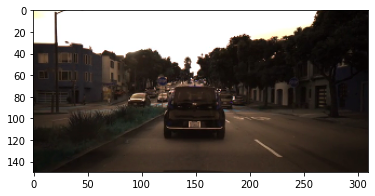

In [36]:
plt.imshow(all_inputs[1][0])

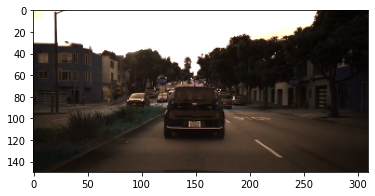

In [37]:
plt.imshow(all_inputs[1][1])

In [0]:
assert len(all_inputs) == len(all_outputs), 'dataset sizes should match'

dataset_size = len(all_inputs)
train_size = int(0.9 * dataset_size)

train_X = all_inputs[:train_size]
train_Y = all_outputs[:train_size]

dev_X = all_inputs[train_size:, :, :, :]
dev_Y = all_outputs[train_size:]

In [0]:
def build_model(input_shape):
    X_input = layers.Input(input_shape)
    X = layers.TimeDistributed(layers.Lambda(lambda x: x / 255.0))(X_input)
    X = layers.TimeDistributed(layers.BatchNormalization())(X)

    X = layers.TimeDistributed(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))(X)
    X = layers.TimeDistributed(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))(X)
    X = layers.TimeDistributed(layers.BatchNormalization())(X)
    X = layers.TimeDistributed(layers.MaxPool2D((2, 2)))(X)

    X = layers.TimeDistributed(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))(X)
    X = layers.TimeDistributed(layers.BatchNormalization())(X)
    X = layers.TimeDistributed(layers.MaxPool2D((2, 2)))(X)

    X = layers.TimeDistributed(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))(X)
    X = layers.TimeDistributed(layers.BatchNormalization())(X)
    X = layers.TimeDistributed(layers.MaxPool2D((2, 2)))(X)

    X = layers.TimeDistributed(layers.Flatten())(X)
    X = layers.SimpleRNN(64)(X)
    X = layers.Dense(32, activation='relu')(X)
    X = layers.Dense(32, activation='relu')(X)
    X = layers.Dense(1)(X)

    model = models.Model(inputs=X_input, outputs=X)
    model.summary()
    return model


In [0]:
#4@title Train Model

MAX_TRAIN_PARAMS = 1e8

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

def train_model(model, train_X, train_Y, dev_X, dev_Y, epochs, callbacks=[]):
  adam = optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
  lr_metric = get_lr_metric(adam)
  model.compile(optimizer=adam,
                loss='mse', 
                metrics= [lr_metric])

  trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
  assert trainable_count < MAX_TRAIN_PARAMS, "trainable params exceeds %d. Aborting..." % MAX_TRAIN_PARAMS

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  callbacks.append(tensorboard_callback)

  print('Mean: train_Y: %f dev_Y: %f' % (np.mean(train_Y), np.mean(dev_Y)))
  print('Variance: train_Y: %f dev_Y: %f' % (np.var(train_Y), np.var(dev_Y)))
  print('Starting training...')
  history = model.fit(x=train_X, 
            y=train_Y,
            batch_size=32,
            epochs=epochs, 
            validation_data=(dev_X, dev_Y), 
            callbacks=callbacks)
  
  plt.plot(history.history['loss'])
  plt.show()

In [0]:
#4@title Evaluate Model

def evaluate(train_X, train_Y, dev_X, dev_Y):
  idx = int(0.8 * len(train_X))

  plt.imshow(train_X[idx])

  print('Train size:', len(train_X))
  print('Dev size:', len(dev_X))
  plot_pred(all_inputs, all_outputs, 100)

def plot_pred(all_inputs, all_outputs, N=1000):
  all_inputs_unshuffled = unshuffle(all_inputs, indices)
  all_outputs_unshuffled = unshuffle(all_outputs, indices)

  fig, ax = plt.subplots(figsize=(20,10))

  predicted = model.predict(all_inputs_unshuffled[:N])

  idx = int(0.8 * N)
  print()
  print('idx: %d, Output: %f, Predicted: %f' % (idx, all_outputs_unshuffled[idx], predicted[idx]))

  plt.plot(predicted)
  plt.plot(all_outputs_unshuffled[:N])

  plt.xlabel('image_index (or time since start)')
  plt.ylabel('speed')
  plt.title('Predicted vs actual on validation data')
  plt.legend(['Predicted speed', 'Actual speed'], loc='upper right')
  plt.show()
  plt.close()

class ShowPlotCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs=None):
    # print('Evaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))
    plot_pred(all_inputs, all_outputs, 1000)

In [0]:
def train_and_evaluate(model, train_X, train_Y, dev_X, dev_Y, epochs):
  train_model(model, train_X, train_Y, dev_X, dev_Y, epochs, callbacks = [ShowPlotCallback()])
  # evaluate(train_X, train_Y, dev_X, dev_Y)

In [52]:
model = build_model(train_X.shape[1:])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2, 150, 310, 3)]  0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 2, 150, 310, 3)    0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, 2, 150, 310, 3)    12        
_________________________________________________________________
time_distributed_41 (TimeDis (None, 2, 148, 308, 32)   896       
_________________________________________________________________
time_distributed_42 (TimeDis (None, 2, 146, 306, 64)   18496     
_________________________________________________________________
time_distributed_43 (TimeDis (None, 2, 146, 306, 64)   256       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 2, 73, 153, 64)    0   

Mean: train_Y: 0.121787 dev_Y: 0.126750
Variance: train_Y: 0.006724 dev_Y: 0.007738
Starting training...
Epoch 1/20
631/632 [============================>.] - ETA: 0s - loss: 0.0156 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.171659


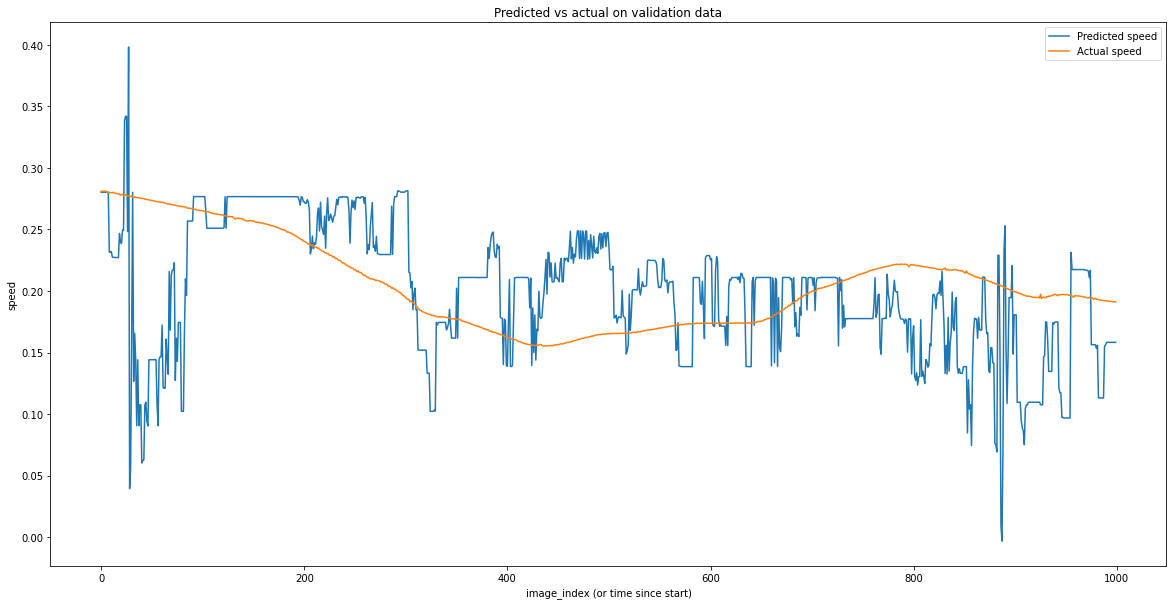

632/632 [==============================] - 109s 172ms/step - loss: 0.0156 - lr: 0.0100
Epoch 2/20
631/632 [============================>.] - ETA: 0s - loss: 0.0024 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.177471


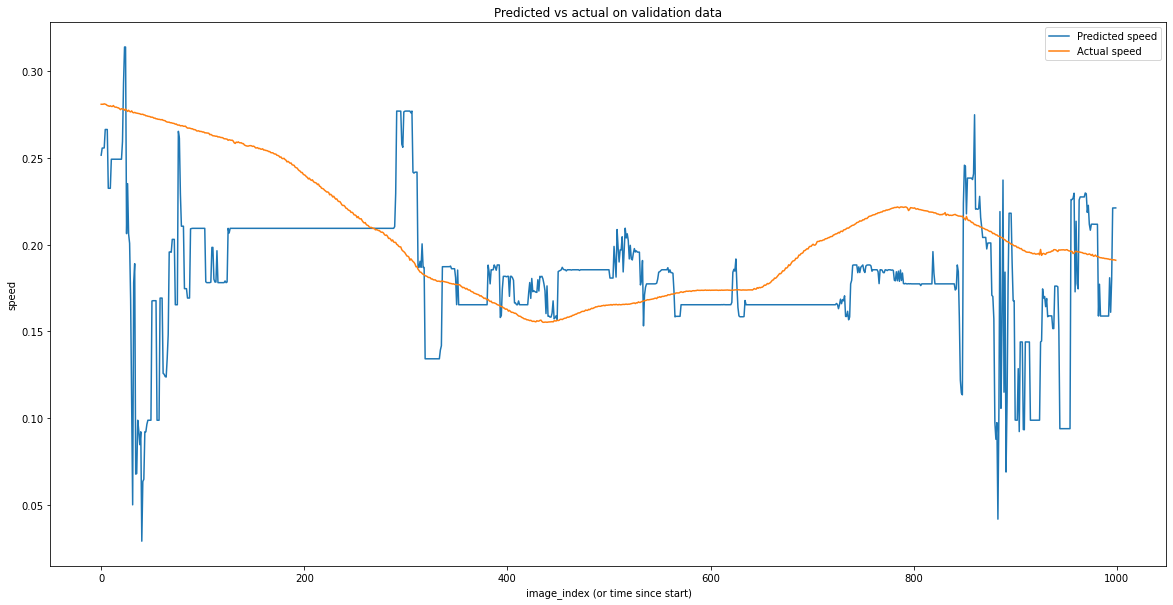

632/632 [==============================] - 110s 174ms/step - loss: 0.0024 - lr: 0.0100
Epoch 3/20
631/632 [============================>.] - ETA: 0s - loss: 0.0018 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.170692


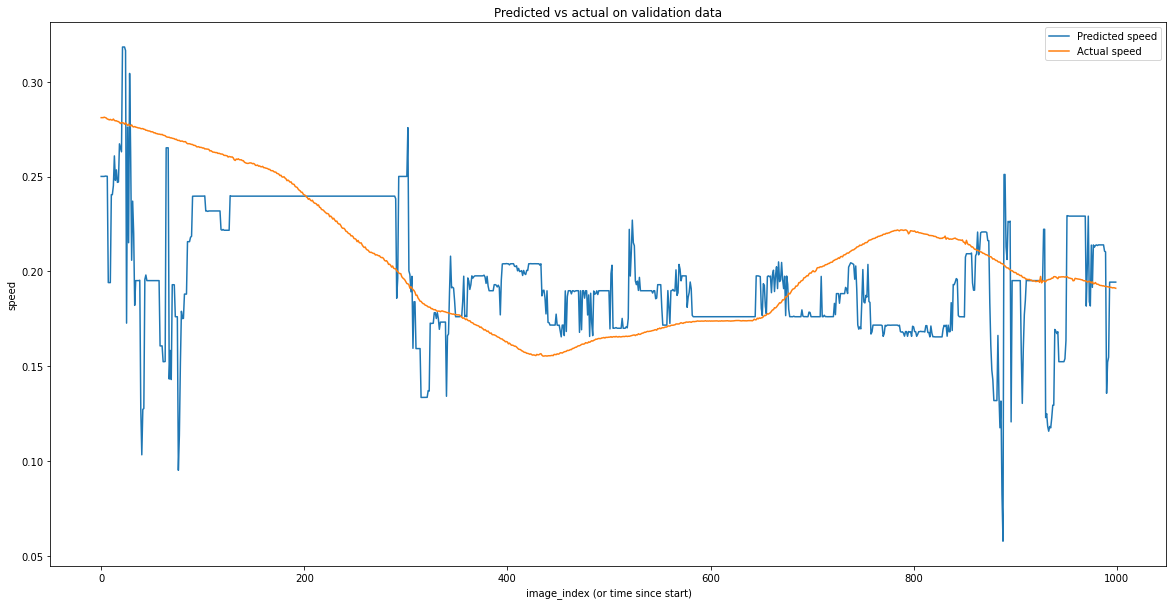

632/632 [==============================] - 108s 171ms/step - loss: 0.0018 - lr: 0.0100
Epoch 4/20
631/632 [============================>.] - ETA: 0s - loss: 0.0015 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.222879


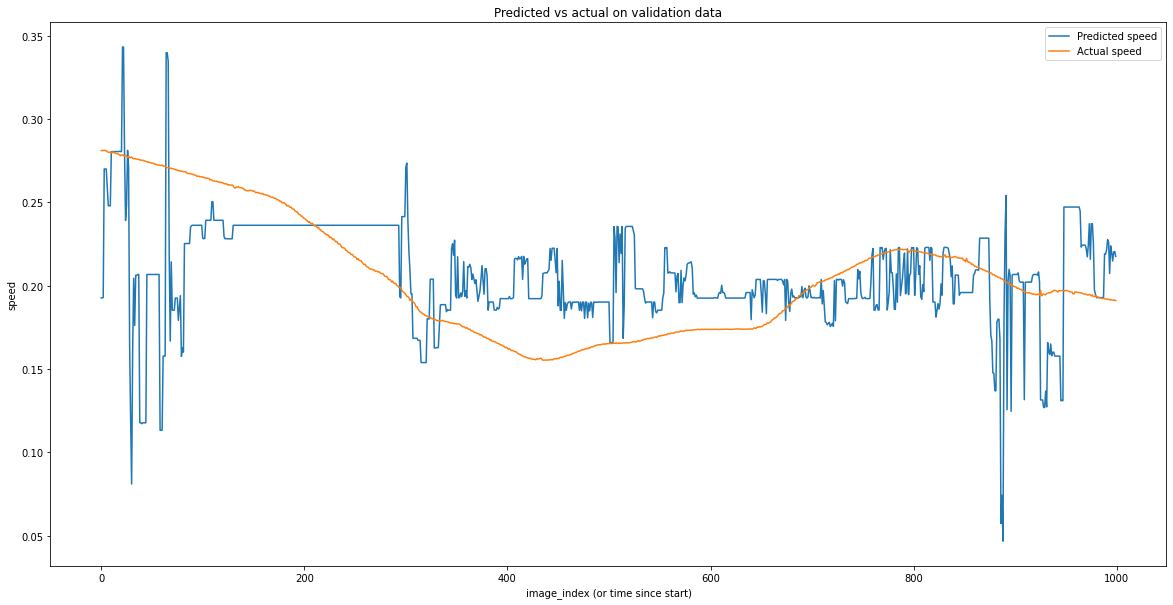

632/632 [==============================] - 108s 170ms/step - loss: 0.0015 - lr: 0.0100
Epoch 5/20
631/632 [============================>.] - ETA: 0s - loss: 0.0014 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.256342


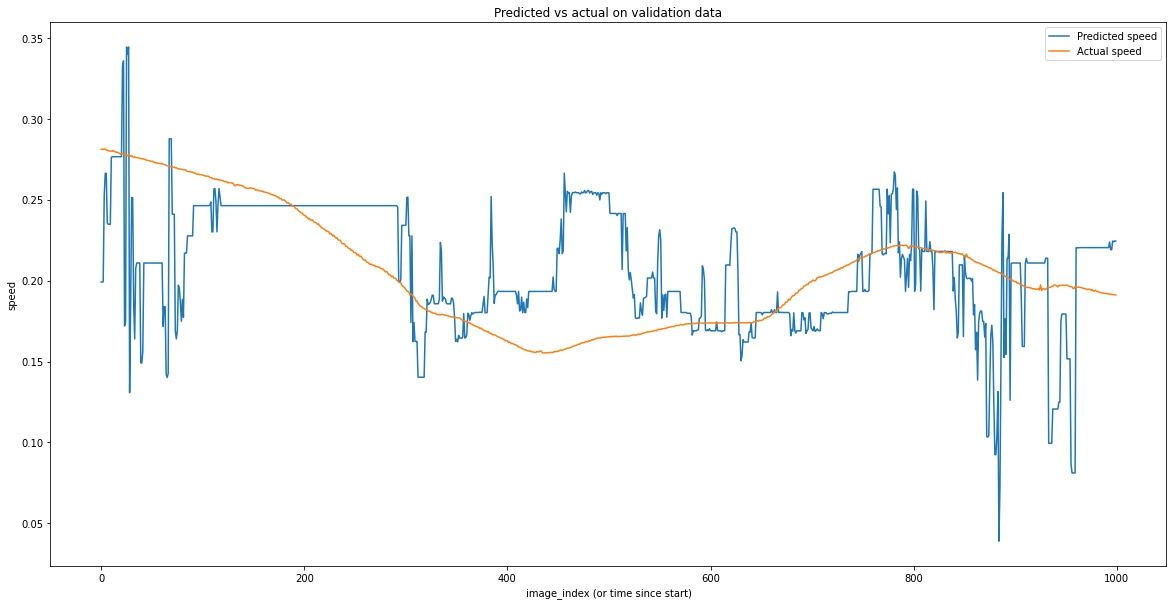

632/632 [==============================] - 108s 170ms/step - loss: 0.0014 - lr: 0.0100
Epoch 6/20
631/632 [============================>.] - ETA: 0s - loss: 0.0012 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.207437


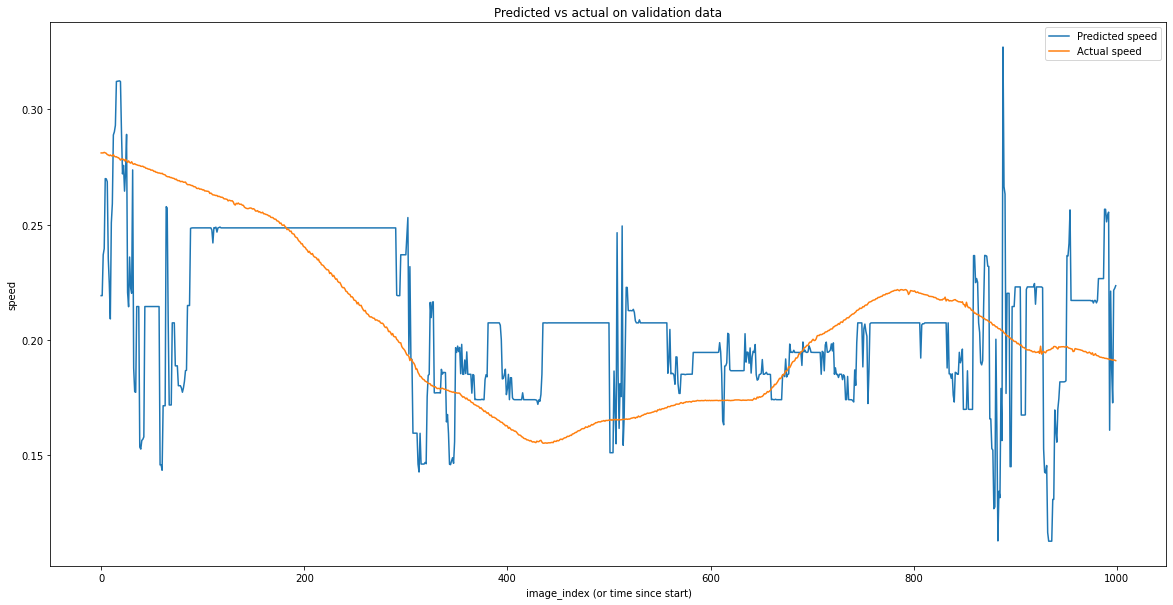

632/632 [==============================] - 108s 171ms/step - loss: 0.0012 - lr: 0.0100
Epoch 7/20
631/632 [============================>.] - ETA: 0s - loss: 0.0011 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.182001


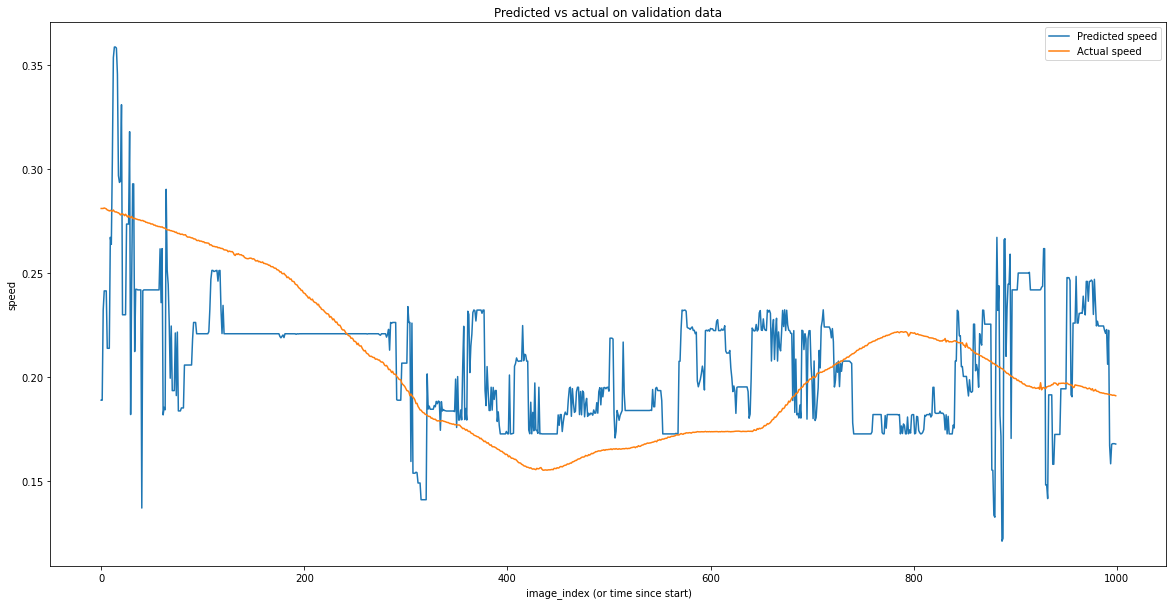

632/632 [==============================] - 108s 171ms/step - loss: 0.0011 - lr: 0.0100
Epoch 8/20
631/632 [============================>.] - ETA: 0s - loss: 0.0010 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.217957


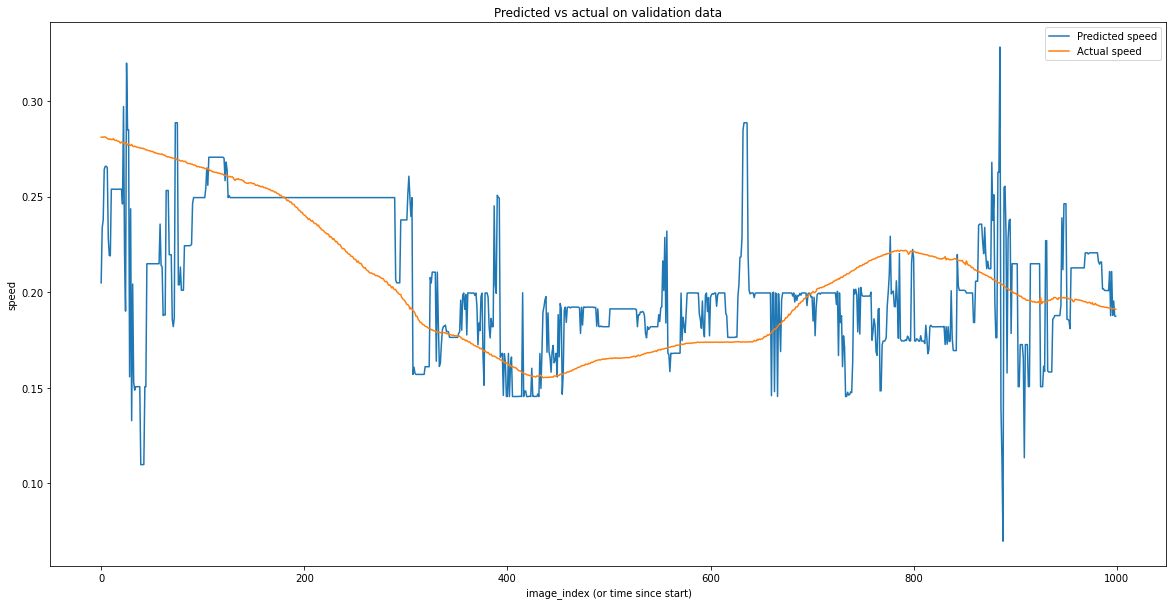

632/632 [==============================] - 108s 171ms/step - loss: 0.0010 - lr: 0.0100
Epoch 9/20
631/632 [============================>.] - ETA: 0s - loss: 9.8755e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.175531


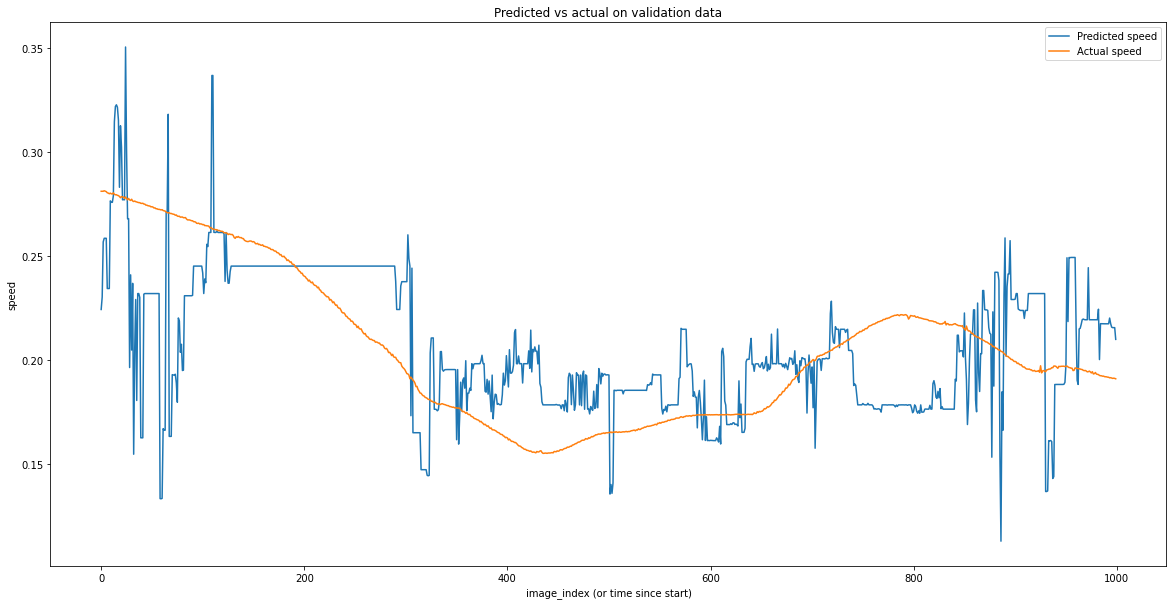

632/632 [==============================] - 108s 171ms/step - loss: 9.8743e-04 - lr: 0.0100
Epoch 10/20
631/632 [============================>.] - ETA: 0s - loss: 9.4671e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.184398


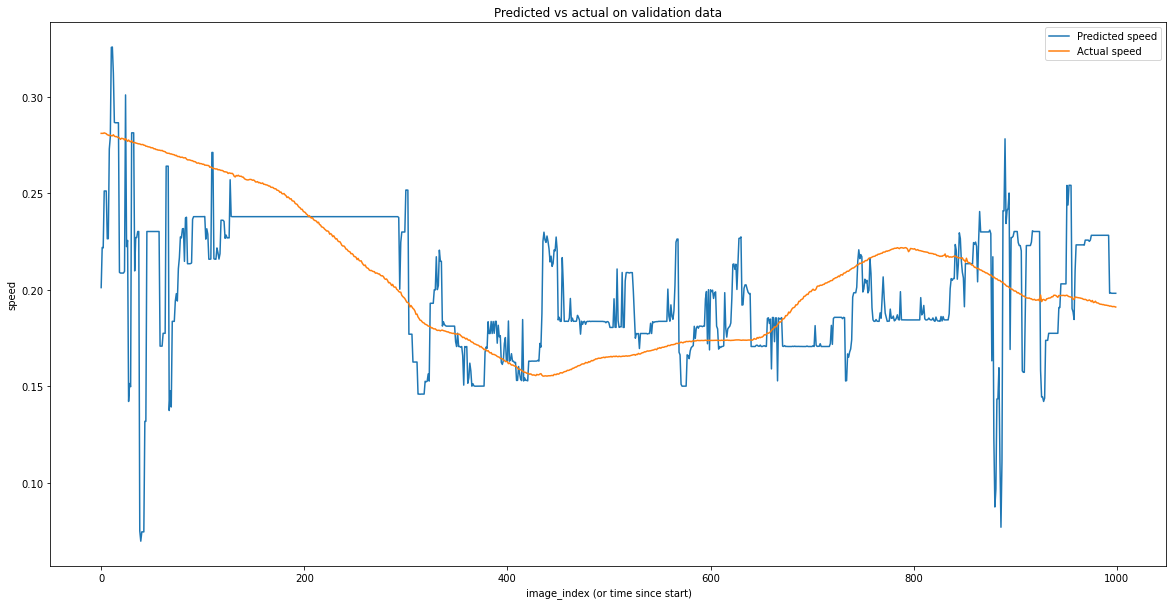

632/632 [==============================] - 108s 170ms/step - loss: 9.4668e-04 - lr: 0.0100
Epoch 11/20
631/632 [============================>.] - ETA: 0s - loss: 9.0932e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.185163


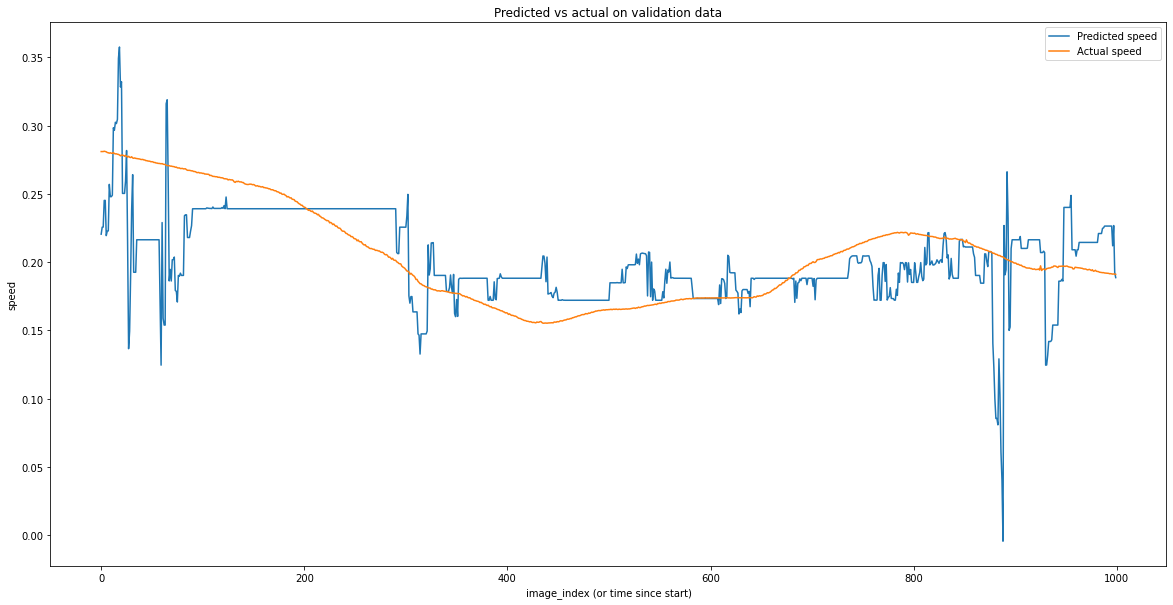

632/632 [==============================] - 108s 170ms/step - loss: 9.1041e-04 - lr: 0.0100
Epoch 12/20
631/632 [============================>.] - ETA: 0s - loss: 8.7459e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.183656


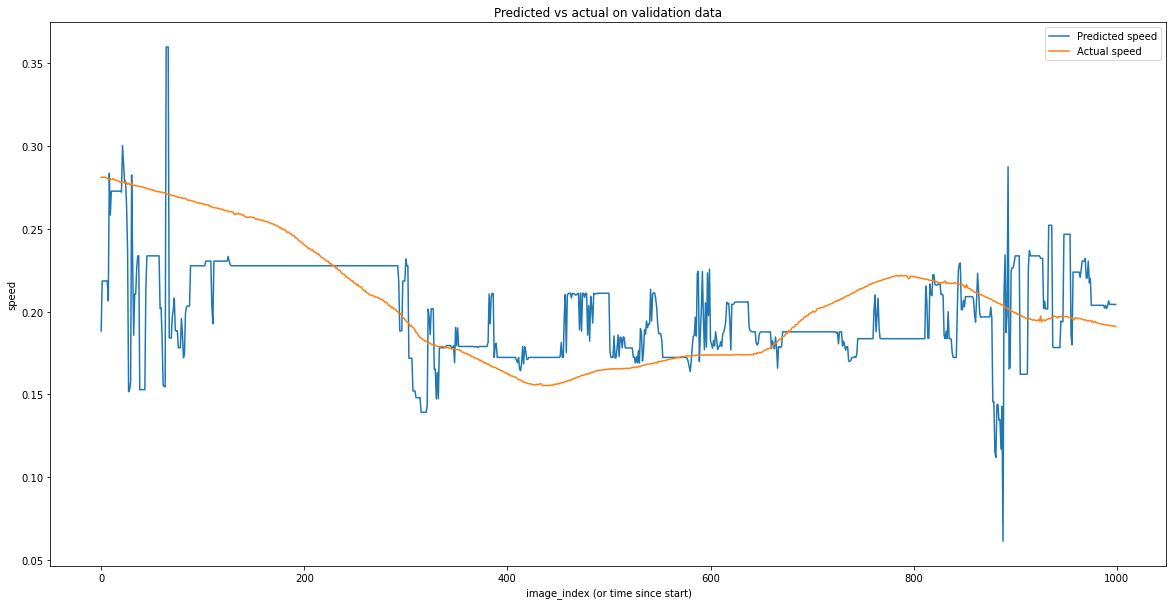

632/632 [==============================] - 108s 170ms/step - loss: 8.7448e-04 - lr: 0.0100
Epoch 13/20
631/632 [============================>.] - ETA: 0s - loss: 8.1747e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.176332


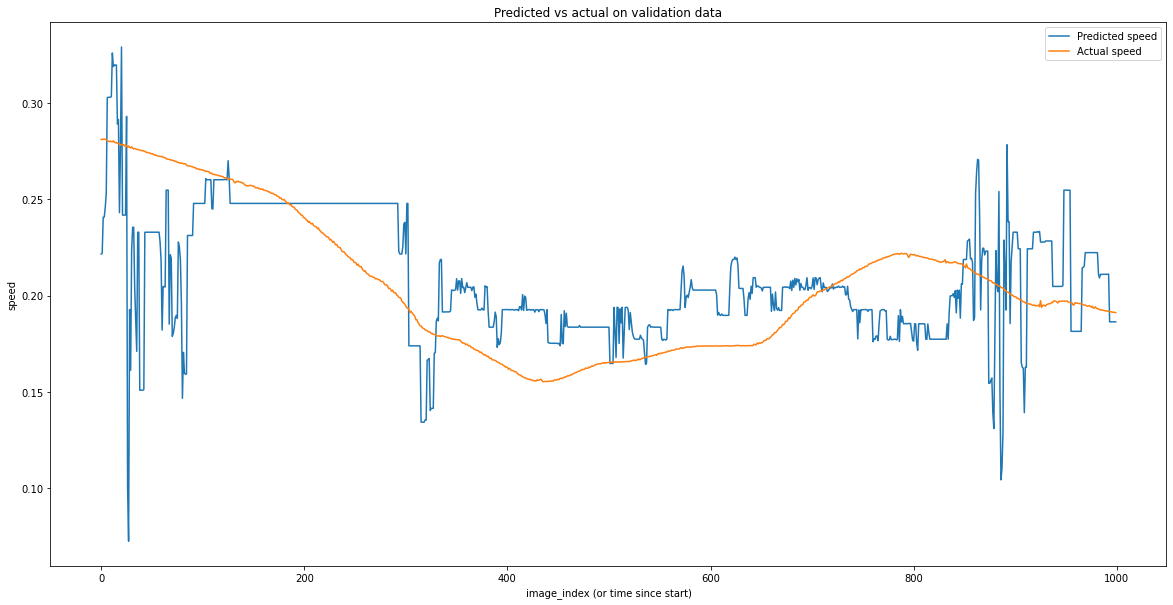

632/632 [==============================] - 107s 170ms/step - loss: 8.1749e-04 - lr: 0.0100
Epoch 14/20
631/632 [============================>.] - ETA: 0s - loss: 7.8554e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.174209


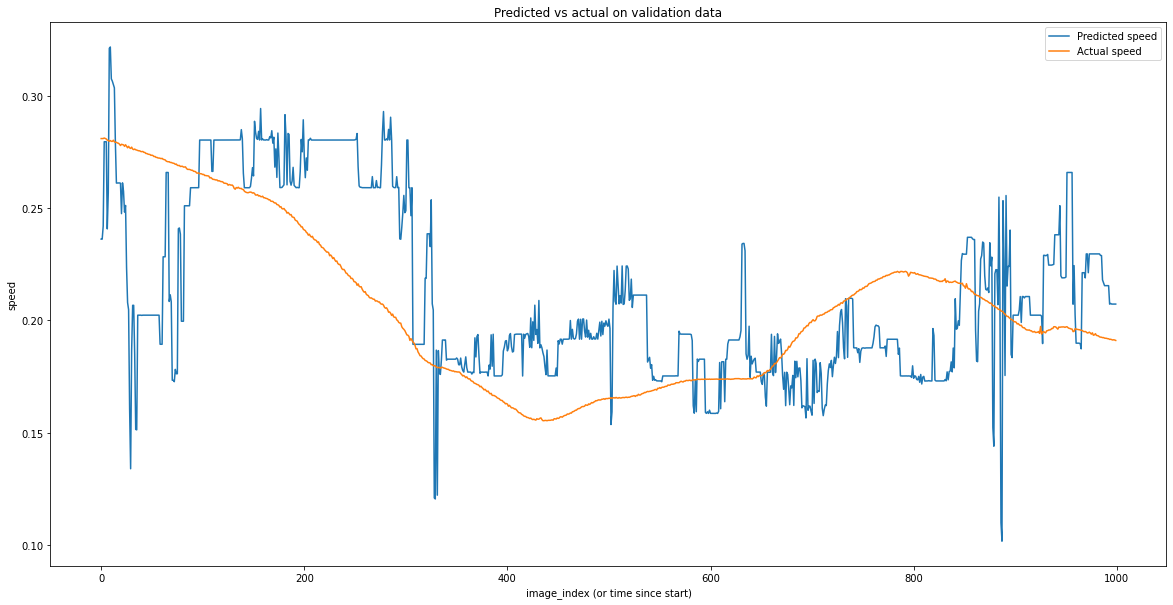

632/632 [==============================] - 107s 170ms/step - loss: 7.8545e-04 - lr: 0.0100
Epoch 15/20
631/632 [============================>.] - ETA: 0s - loss: 7.3447e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.194482


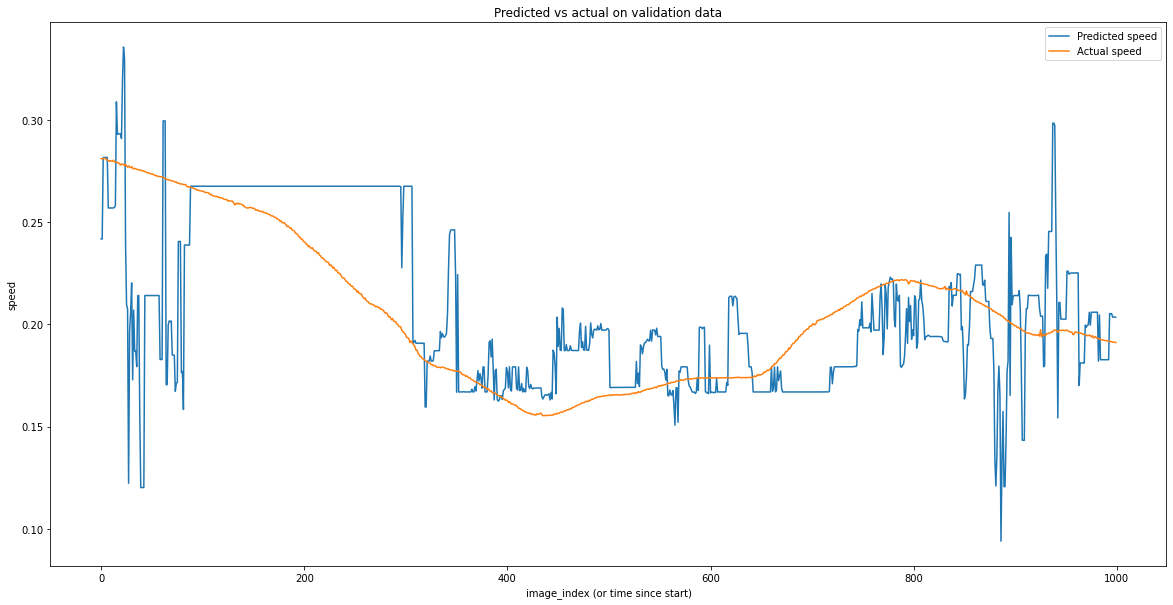

632/632 [==============================] - 107s 170ms/step - loss: 7.3441e-04 - lr: 0.0100
Epoch 16/20
631/632 [============================>.] - ETA: 0s - loss: 7.4495e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.232731


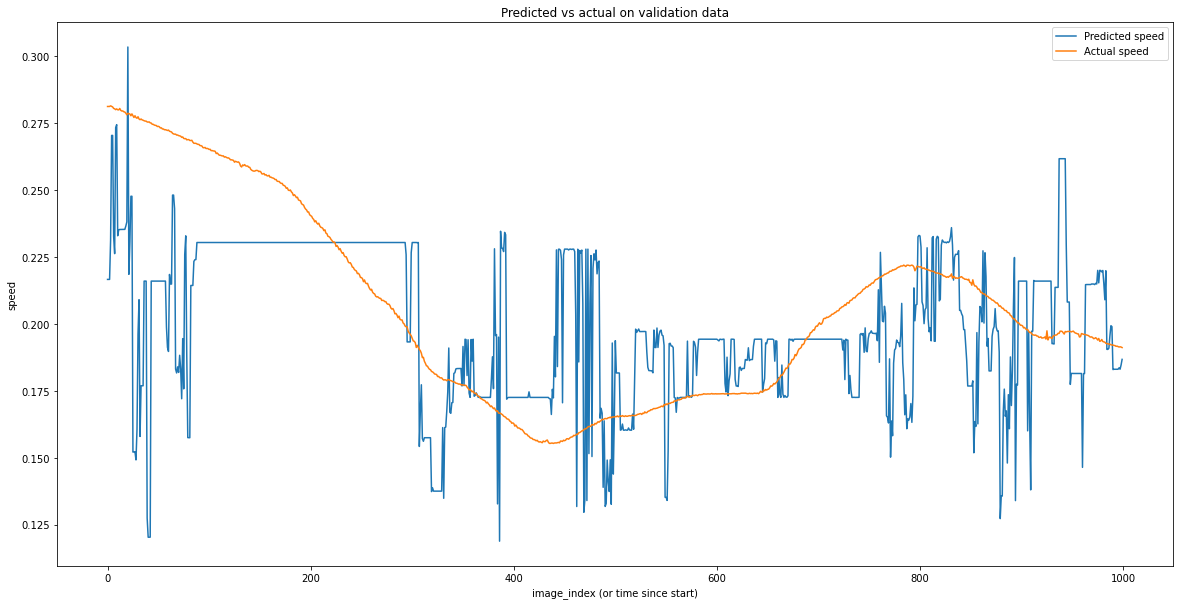

632/632 [==============================] - 107s 170ms/step - loss: 7.4492e-04 - lr: 0.0100
Epoch 17/20
631/632 [============================>.] - ETA: 0s - loss: 6.5899e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.200823


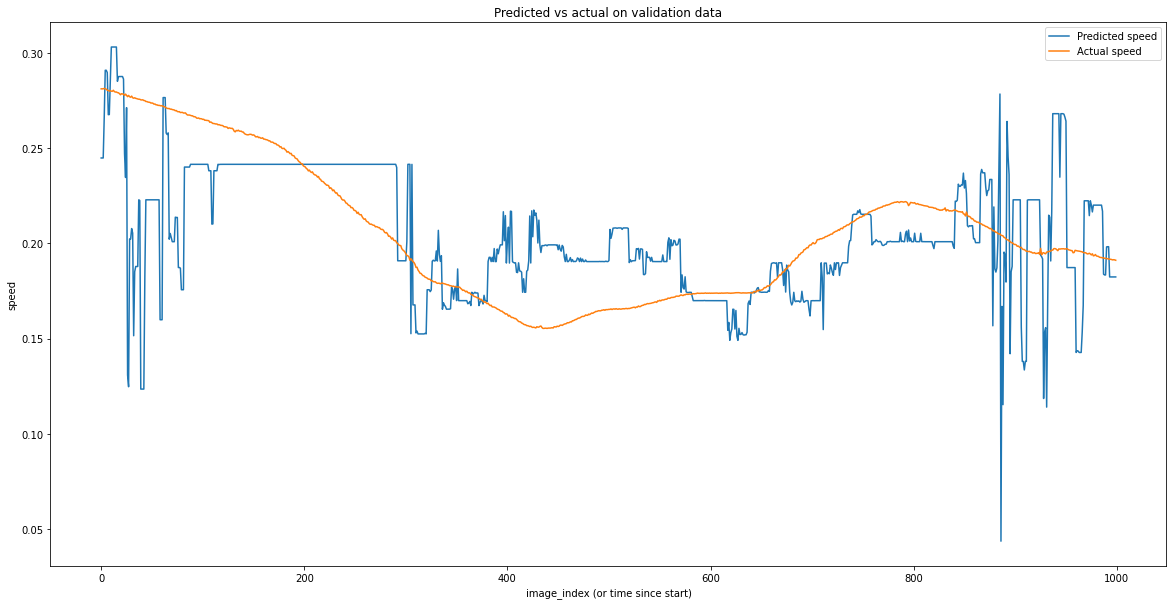

632/632 [==============================] - 108s 170ms/step - loss: 6.5903e-04 - lr: 0.0100
Epoch 18/20
631/632 [============================>.] - ETA: 0s - loss: 6.4303e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.179273


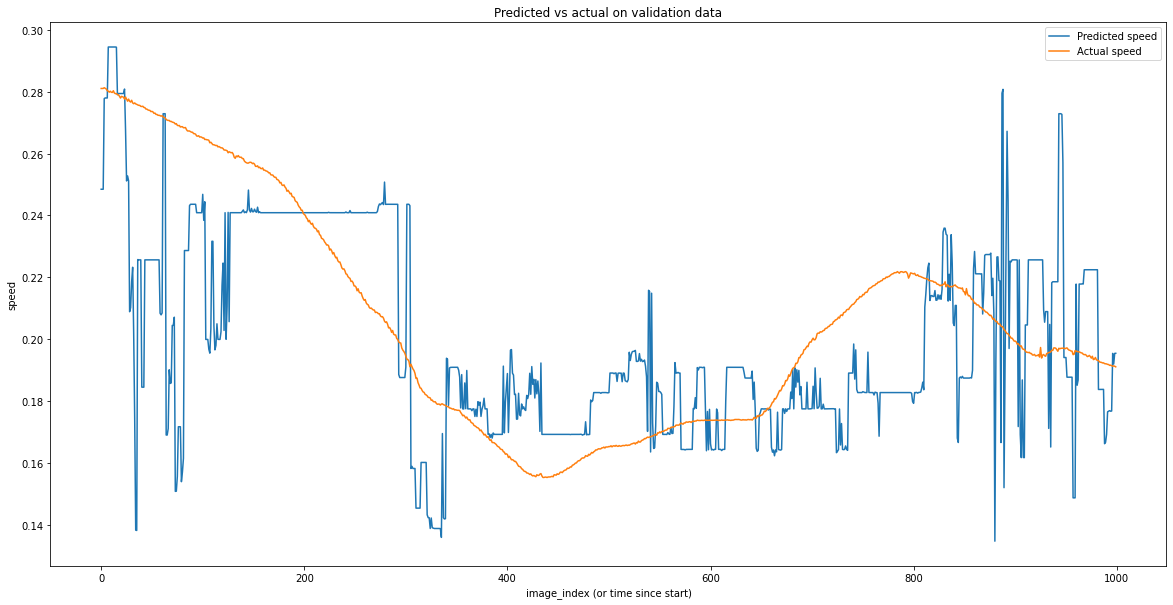

632/632 [==============================] - 108s 170ms/step - loss: 6.4329e-04 - lr: 0.0100
Epoch 19/20
631/632 [============================>.] - ETA: 0s - loss: 5.9357e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.219741


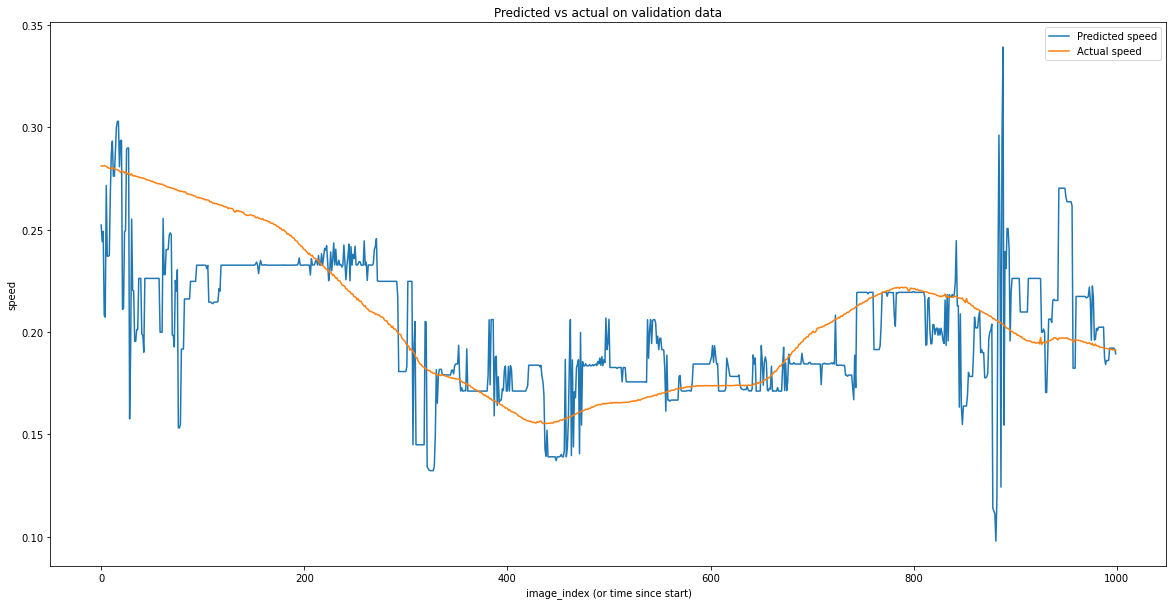

632/632 [==============================] - 108s 170ms/step - loss: 5.9355e-04 - lr: 0.0100
Epoch 20/20
631/632 [============================>.] - ETA: 0s - loss: 5.7567e-04 - lr: 0.0100
idx: 800, Output: 0.221121, Predicted: 0.207559


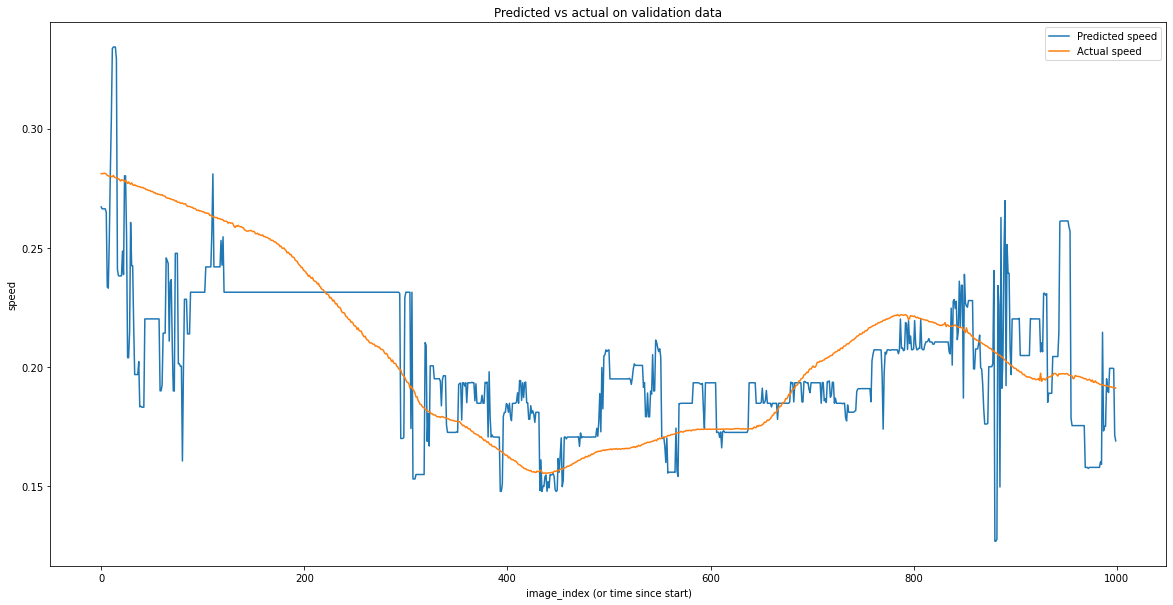

632/632 [==============================] - 108s 170ms/step - loss: 5.7669e-04 - lr: 0.0100


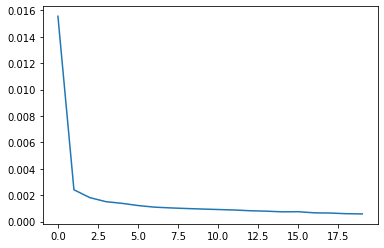

In [53]:
train_size = len(train_X)
dev_size = len(dev_X)
train_and_evaluate(model, train_X[:train_size], train_Y[:train_size], dev_X[:dev_size], dev_Y[:dev_size], 20)


idx: 16319, Output: 0.097598, Predicted: 0.096397


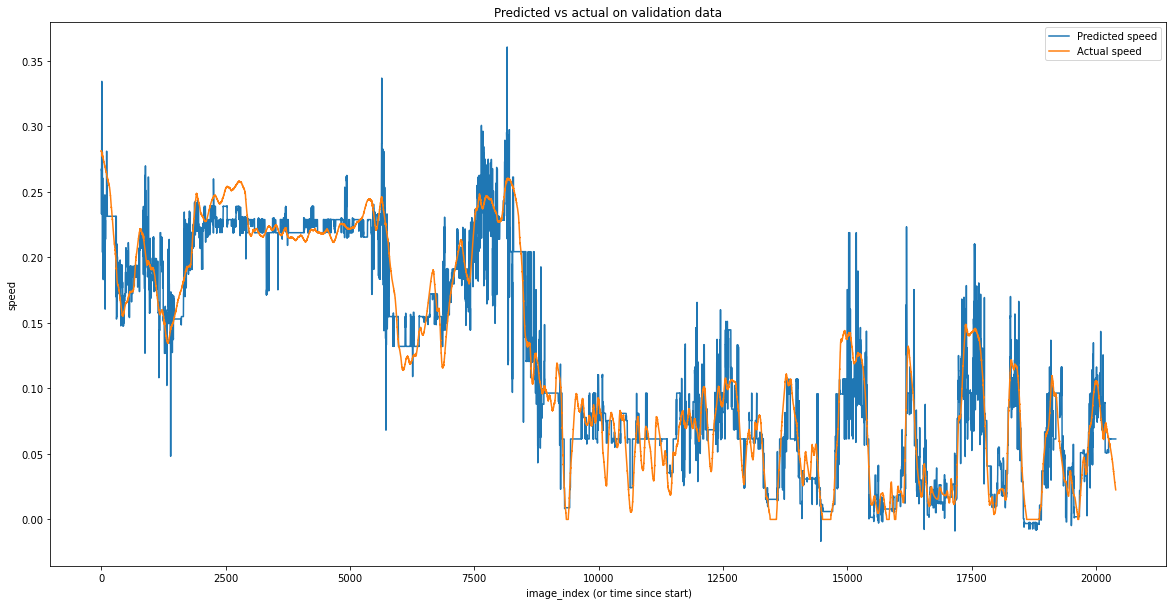

In [54]:
plot_pred(all_inputs, all_outputs, len(all_inputs))

In [0]:
%tensorboard --logdir logs